In [1]:
import uproot
import awkward as ak
import numpy as np
import math
import sklearn.metrics as m
import numba as nb
from coffea.nanoevents.methods import vector
import os

import boost_histogram as bh
from matplotlib import pyplot as plt
import matplotlib as mpl
from cycler import cycler
import mplhep as hep
use_helvet = True  ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

import os, sys  
sys.path.insert(1, '/data/pku/home/licq/cH/zz_v2/selection/analyzer')

In [78]:
from glob import glob
fileset = {
    # 'ggH125': glob('/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18_r2_main/GluGluHToZZTo4L_M125_TuneCP5_13TeV_powheg2_JHUGenV7011_pythia8/*/*/*/*.root'),
    # 'HC_3FS': glob('/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18_r2_main/HPlusCharm_3FS_MuRFScaleDynX0p50_HToZZTo4L_M125_TuneCP5_13TeV_amcatnlo_JHUGenV7011_pythia8/*/*/*/*.root'),
    # 'HC_4FS': glob('/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18_r2_main/HPlusCharm_4FS_MuRFScaleDynX0p50_HToZZTo4L_M125_TuneCP5_13TeV_amcatnlo_JHUGenV7011_pythia8/*/*/*/*.root'),
    # 'HC_4FSFxFx': glob('/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18_r2_main/HPlusCharm_4FS_MuRFScaleDynX0p50_HToZZTo4L_M125_TuneCP5_13TeV_amcatnloFXFX_JHUGenV7011_pythia8/*/*/*/*.root'),
    'ggTo4e_Contin_MCFM701': glob('/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18_r2_main_ext1/GluGluToContinToZZTo4e_TuneCP5_13TeV-mcfm701-pythia8/*/*/*/*.root'),
    'ggTo4mu_Contin_MCFM701': glob('/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18_r2_main_ext1/GluGluToContinToZZTo4mu_TuneCP5_13TeV-mcfm701-pythia8/*/*/*/*.root'),
    'ggTo4tau_Contin_MCFM701': glob('/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18_r2_main_ext1/GluGluToContinToZZTo4tau_TuneCP5_13TeV-mcfm701-pythia8/*/*/*/*.root'),
    'ggTo2e2mu_Contin_MCFM701': glob('/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18_r2_main_ext1/GluGluToContinToZZTo2e2mu_TuneCP5_13TeV-mcfm701-pythia8/*/*/*/*.root'),
    'ggTo2e2tau_Contin_MCFM701': glob('/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18_r2_main_ext1/GluGluToContinToZZTo2e2tau_TuneCP5_13TeV-mcfm701-pythia8/*/*/*/*.root'),
    'ggTo2mu2tau_Contin_MCFM701': glob('/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18_r2_main_ext1/GluGluToContinToZZTo2mu2tau_TuneCP5_13TeV-mcfm701-pythia8/*/*/*/*.root'),
    'ZZTo4lext': glob('/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18_r2_main_ext1/ZZTo4L_TuneCP5_13TeV_powheg_pythia8/*/*/*/*.root'),
}
lumi = 59.83 * 1e3

# df = {}
for sam in fileset:
    print(sam)
    df[sam] = uproot.lazy([f+':Ana/passedEvents' for f in fileset[sam]])
    df[sam]['gen_sum_weights'] = sum([uproot.open(f+':Ana/sumWeights').to_numpy()[0][0] for f in fileset[sam]])
    df[sam]['weight'] = df[sam].eventWeight * lumi / df[sam]['gen_sum_weights']
    df[sam] = df[sam][df[sam].passedFullSelection]

ggTo4e_Contin_MCFM701
ggTo4mu_Contin_MCFM701
ggTo4tau_Contin_MCFM701
ggTo2e2mu_Contin_MCFM701
ggTo2e2tau_Contin_MCFM701
ggTo2mu2tau_Contin_MCFM701
ZZTo4lext


KeyboardInterrupt: 

# Preprocessing

In [24]:
ak.fill_none(df[sam]['genFlavour'], 0)

<Array [0, 0, 0, 0, 0, 0, ... 0, 0, 5, 0, 0, 0] type='119599 * float64'>

In [31]:
ak.fill_none(ak.values_astype(ak.max(df[sam].GENjet_hadronFlavour, axis=1), 'int32'), 0)

<Array [0, 0, 0, 0, 0, 0, ... 0, 0, 5, 0, 0, 0] type='119599 * int64'>

In [35]:
d = {k: {} for k in df.keys()}
for sam in ['ggH125', 'HC_4FSFxFx']:
    print(sam)
    d[sam]['genFlavour'] = ak.fill_none(ak.values_astype(ak.max(df[sam].GENjet_hadronFlavour, axis=1), 'int'), 0)

ggH125
HC_4FSFxFx


In [65]:
for sam in ['ggH125', 'HC_4FSFxFx']:
    print(sam)
    # recon_cleaned_sv(df[sam], d[sam], force_all=True)
    recon_cleaned_jet(df[sam], d[sam])

ggH125
++ setting up jets
HC_4FSFxFx
++ setting up jets


# Plotting

In [64]:
from importlib import reload
import plotter, cutflow
make_plot_flv = reload(plotter).make_plot_flv
recon_cleaned_sv = reload(cutflow).recon_cleaned_sv
recon_cleaned_jet = reload(cutflow).recon_cleaned_jet

In [67]:
d[sam]['cleaned_jet'].pt

<Array [[36.7, 19.8, 14.1], ... 18.4, 18], []] type='628584 * var * float32'>

[0.18612874] [0.05817265]


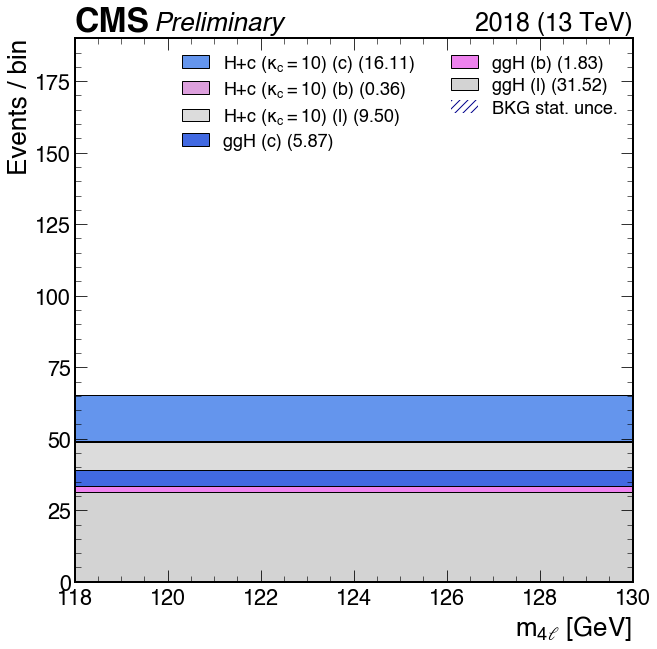

In [77]:
# slice_str = ""; make_plot_flv(title='test', df=df, dfext=d,
#     nbin=1, xmin=118, xmax=130, kc=10, 
#     content_arr=f'df.mass4l',
#     flv_arr="d['genFlavour']",
#     weight_arr='df.weight',
#     xlabel=r'$m_{4\ell}$ [GeV]', ylabel='Events / bin', ylog=False,
#     custom_command="ax.legend(prop={'size': 18}, ncol=2, labelspacing=0.3, borderpad=0.3)",
# )

# one jet
# slice_str = "ak.sum((d['cleaned_jet'].pt>10) & (d['cleaned_jet'].DeepJet_CvsL>0.), axis=1)>0"; make_plot_flv(title='test', df=df, dfext=d,
# slice_str = "ak.sum((d['cleaned_sv'].pt>0), axis=1)>0"; make_plot_flv(title='test', df=df, dfext=d,
slice_str = "ak.sum((df['sv_pt']>0), axis=1)>0"; make_plot_flv(title='test', df=df, dfext=d,
    nbin=1, xmin=118, xmax=130, kc=10, 
    content_arr=f'df.mass4l[{slice_str}]',
    flv_arr=f"d['genFlavour'][{slice_str}]",
    weight_arr=f'df.weight[{slice_str}]',
    xlabel=r'$m_{4\ell}$ [GeV]', ylabel='Events / bin', ylog=False,
    custom_command="ax.legend(prop={'size': 18}, ncol=2, labelspacing=0.3, borderpad=0.3); ax.set_ylim(0, 190)",
)

In [5]:
df['ggH125'][1].GENjet_hadronFlavour

<Array [0, 0, 0, 0, 0] type='5 * float32'>

In [4]:
ak.fields(df['HC_4FSFxFx'])

['Run',
 'Event',
 'LumiSect',
 'nVtx',
 'nInt',
 'PV_x',
 'PV_y',
 'PV_z',
 'BS_x',
 'BS_y',
 'BS_z',
 'BS_xErr',
 'BS_yErr',
 'BS_zErr',
 'BeamWidth_x',
 'BeamWidth_y',
 'BeamWidth_xErr',
 'BeamWidth_yErr',
 'finalState',
 'triggersPassed',
 'passedTrig',
 'passedFullSelection',
 'passedZ4lSelection',
 'passedQCDcut',
 'passedZ1LSelection',
 'passedZ4lZ1LSelection',
 'passedZ4lZXCRSelection',
 'passedZXCRSelection',
 'nZXCRFailedLeptons',
 'genWeight',
 'k_ggZZ',
 'k_qqZZ_qcd_dPhi',
 'k_qqZZ_qcd_M',
 'k_qqZZ_qcd_Pt',
 'k_qqZZ_ewk',
 'qcdWeights',
 'nnloWeights',
 'pdfWeights',
 'pdfRMSup',
 'pdfRMSdown',
 'pdfENVup',
 'pdfENVdown',
 'pileupWeight',
 'pileupWeightUp',
 'pileupWeightDn',
 'dataMCWeight',
 'eventWeight',
 'prefiringWeight',
 'prefiringWeightECAL',
 'prefiringWeightMuon',
 'crossSection',
 'lep_d0BS',
 'lep_d0PV',
 'lep_numberOfValidPixelHits',
 'lep_trackerLayersWithMeasurement',
 'lep_p',
 'lep_ecalEnergy',
 'lep_isEB',
 'lep_isEE',
 'singleBS_Lep_pt',
 'singleBS_Lep_p